In [172]:
#create a local RAG 



<h1>Retrieval Augmented Generation</h1>
Take information and pass it to an LLM so it can generate outputs

<ul>
<li> Retrieval
    - find relevant information given a query
    - "what are macronutrients?" -> retrievals passages </li>

<li> Augmented
    - we want to take relevant information and augment our input (prompt)</li>

<li>Generation
- Take the first two steps and pass them to an LLM for generative outputs </li>
</ul>
<h3>Why RAG?</h3>
<ul> 
    <li>Prevents hallucinations</li>
    <li>Uses factual relevant information</li>
</ul>

    


<h2>The plan </h2>
<ol> 
<li> Open a PDF </li>
<li> Format the text for an embedding model </li>
<li> Embed all the chunks of text and turn them into numerical representatiosn (embedding) </li>
<li> Build retrieval system that uses vector search to find relevatn chunk of text based on a query </li>
<li> Create a prompt that incoporates retrieved pieces of text </li>
<li> Generate an aswer to a query based on passaged </li>
</ol>

Document / text proccessing and embedding creation

Ingredients
<ul>
<li> Import PDF doc</li>
<li> Process text for embedding</li>
<li>Embed text chunks</li>
<li> Save embeddings for later</li>
</ul>

In [173]:
#Import PDF document
import os
import requests

pdf_path = "human-nutrition-text.pdf"
print(os.path.exists(pdf_path))

True


In [174]:
#open the PDF
!pip install -r requirements.txt


In [175]:
import fitz
from tqdm.auto import tqdm

#remove the new line characters
def text_formatter(text: str) -> str:
    cleaned_text = text.replace("\n", " ").strip()
    return cleaned_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text=text)
        pages_and_texts.append({"page_number": page_number - 41,  #subtract page number to match the actual start of content
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4, #one token roughly for characters
                                "text": text}) 
    return pages_and_texts
    

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
                                


0it [00:00, ?it/s]

In [176]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 288,
  'page_char_count': 649,
  'page_word_count': 108,
  'page_sentence_count_raw': 5,
  'page_token_count': 162.25,
  'text': 'features interactive learning activities.  These activities are  available in the web-based textbook and not available in the  downloadable versions (EPUB, Digital PDF, Print_PDF, or  Open Document).  Learning activities may be used across various mobile  devices, however, for the best user experience it is strongly  recommended that users complete these activities using a  desktop or laptop computer and in Google Chrome.    An interactive or media element has been  excluded from this version of the text. You can  view it online here:  http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=194    288  |  Carbohydrates and Personal Diet Choices'},
 {'page_number': 363,
  'page_char_count': 1726,
  'page_word_count': 301,
  'page_sentence_count_raw': 12,
  'page_token_count': 431.5,
  'text': 'Defining Protein  UNIVERSITY OF HAWAI‘I AT MĀNOA FOO

In [177]:
import pandas as pd

df= pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,147,3,199.25,Contents Preface University of Hawai‘i at Mā...


In [178]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00
std,348.86,560.38,95.83,6.55,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,5.00,190.50
50%,562.50,1231.50,216.00,10.00,307.88
75%,864.25,1603.50,272.00,15.00,400.88
max,1166.00,2308.00,430.00,39.00,577.00


Tokens are thought as pieces of words

Tokens count is important to think about because: 

 <ol> 
 <li> Embedding models dont deal with infinite tokens </li>
 <li> LLMS dont deal with infinite tokens </li>

 </ol>

 An embedding model might have been trained to embed sequenses of 384 tokens, so we need to know that (sentence-transformers)

 LLMs cant accept infinite tokens in their context window
 - amount of tokens an LLM can accept as input

How do we split the pages into chunks
<ol> 
 <li> can be done by splitting on ". "</li>
 <li> spacy </li>


</ol>

In [179]:
!pip install -U pip setuptools wheel
!pip install -U spacy


  Using cached pip-24.0-py3-none-any.whl.metadata (3.6 kB)
  Using cached setuptools-69.5.1-py3-none-any.whl.metadata (6.2 kB)
  Using cached wheel-0.43.0-py3-none-any.whl.metadata (2.2 kB)
Using cached pip-24.0-py3-none-any.whl (2.1 MB)
Using cached setuptools-69.5.1-py3-none-any.whl (894 kB)
Using cached wheel-0.43.0-py3-none-any.whl (65 kB)


ERROR: To modify pip, please run the following command:
C:\Users\georg\anaconda3\python.exe -m pip install -U pip setuptools wheel


In [180]:
#splitting pages into sentences
from spacy.lang.en import English

nlp = English()

nlp.add_pipe("sentencizer")

doc = nlp("this is .. a sentence. and this is another. I like coffee")
assert len(list(doc.sents)) == 3

list(doc.sents)

[this is .. a sentence., and this is another., I like coffee]

In [181]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    item["page_sentence_count_spacy"] = len(item["sentences"])



  0%|          | 0/1208 [00:00<?, ?it/s]

In [182]:
random.sample(pages_and_texts, k=1)

[{'page_number': 817,
  'page_char_count': 2025,
  'page_word_count': 378,
  'page_sentence_count_raw': 17,
  'page_token_count': 506.25,
  'text': 'the total energy expenditure and resulting energy needs. For  example, the equation for the first three months of life is (89 x  weight [kg] −100) + 175 kcal.  Based on these equations, the estimated energy requirement for  infants from zero to six months of age is 472 to 645 kilocalories per  day for boys and 438 to 593 kilocalories per day for girls. For infants  ages six to twelve months, the estimated requirement is 645 to 844  kilocalories per day for boys and 593 to 768 kilocalories per day for  girls. From the age one to age two, the estimated requirement rises  to 844–1,050 kilocalories per day for boys and 768–997 kilocalories  per day for girls.10 How often an infant wants to eat will also change  over time due to growth spurts, which typically occur at about two  weeks and six weeks of age, and again at about three months and si

In [183]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32
std,348.86,560.38,95.83,6.55,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00


Splitting our text into smaller ones is text splitting / chunking. No best practice for this - experiment

split into groups of 10 for now. Frameworks like langchain that can help.

makes text easier to filter and allow them to fit into our embedding models context window. Means our contexts passed to an LLM are more focused.


In [184]:
## chunking our text into smaller groups
## define our split size

num_sentence_chunk_size = 10

# recursivley split lists of text into chunk size
# eg [20] -> [10,10]
def split_list(input_list: list[str], slice_size: int) -> list[list[str]]:
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

test_list = list(range(35))
split_list(test_list, 10)


[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
 [30, 31, 32, 33, 34]]

In [185]:
#loop through pages

for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list = item["sentences"], slice_size = num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [186]:
random.sample(pages_and_texts, 1)

[{'page_number': -13,
  'page_char_count': 379,
  'page_word_count': 69,
  'page_sentence_count_raw': 4,
  'page_token_count': 94.75,
  'text': 'Students  Noemi Arceo Caacbay  Noemi Arceo Caacbay is a Masters Student in the Public Health,  Health Policy and Management Program at the University of Hawai‘i  at Mānoa. She enjoys learning about all things health-science  related. She is passionate about returning to her home of Saipan,  CNMI where she will give back and serve her community.  About the Contributors  |  xxix',
  'sentences': ['Students  Noemi Arceo Caacbay  Noemi Arceo Caacbay is a Masters Student in the Public Health,  Health Policy and Management Program at the University of Hawai‘i  at Mānoa.',
   'She enjoys learning about all things health-science  related.',
   'She is passionate about returning to her home of Saipan,  CNMI where she will give back and serve her community.',
   ' About the Contributors  |  xxix'],
  'page_sentence_count_spacy': 4,
  'sentence_chunks': 

In [187]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32,1.53
std,348.86,560.38,95.83,6.55,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00,1.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00,1.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00,2.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00,3.00


Splitting each chunk into its own item

embed each chunk of sentences into its own numerical representations
 good level of granularity, means we can dive specifically into the text sample

In [188]:
import re

#each chunk into its own item

pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        #join into a paragraph like structure. eg join sentences into one
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_Sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # .A -> . A (adds the space to sentence starts)
        chunk_dict["sentence_chunk"] = joined_sentence_chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [189]:
random.sample(pages_and_chunks, 1)

[{'page_number': 733,
  'sentence_chunk': 'As such, health claims such as “Three grams of soluble fiber from oatmeal daily in combination with a diet low in cholesterol and saturated fat may reduce the risk of heart disease,” must be evaluated by the FDA before it may appear on packaging. Prior to the passage of the NLEA products that made such claims were categorized as drugs and not food.All health claims must be substantiated by scientific evidence in order for it to be approved and put on a food label.To avoid having companies making false claims, laws also regulate how health claims are presented on food packaging.In addition to the claim being backed up by scientific evidence, it may never claim to diagnose, mitigate, cure or treat the disease.For a detailed list of approved health claims, visit: https://www.fda.gov/food/food-labeling-nutrition/authorized- health-claims-meet-significant-scientific-agreement-ssa-standard Discovering Nutrition Facts | 733',
  'chunk_char_count': 93

In [190]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,730.55,109.19,182.64
std,347.79,445.59,69.34,111.40
min,-41.00,12.00,3.00,3.00
25%,280.50,313.00,43.00,78.25
50%,586.00,743.00,111.00,185.75
75%,890.00,1112.00,168.00,278.00
max,1166.00,1823.00,290.00,455.75


Some chunks aren't worth processing as they are tiny chunks. So think about filtering those out to save computation

In [191]:
min_token_length = 30

for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f"Chunk T count: {row[1]['chunk_token_count']} | Text: {row[1]['sentence_chunk']}")

Chunk T count: 12.5 | Text: Figure 11.2 The Structure of Hemoglobin Iron | 655
Chunk T count: 9.0 | Text: 1088 | Nutrition, Health and Disease
Chunk T count: 28.25 | Text: A concentration gradient is a form of potential energy, like water 172 | Electrolytes Important for Fluid Balance
Chunk T count: 16.0 | Text: Accessed January 20, 2018. 1032 | The Effect of New Technologies
Chunk T count: 12.5 | Text: https://www.fda.gov/food/ 1022 | Food Preservation


In [192]:
#Filter our dataframe for rows under 30 T

pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [193]:
random.sample(pages_and_chunks_over_min_token_len, 1)

[{'page_number': 817,
  'sentence_chunk': 'Infants have a high need for protein to support growth and development, although excess protein (which is only a concern with bottle-feeding) can cause dehydration, diarrhea, fever, and acidosis in premature infants.About 30 to 50 percent of the 10.Food and Nutrition Board, Institute of Medicine. (2005). Dietary reference intakes for energy, carbohydrate, fiber, fat, fatty acids, cholesterol, protein, and amino acids.The National Academies Press. Infancy | 817',
  'chunk_char_count': 464,
  'chunk_word_count': 67,
  'chunk_token_count': 116.0}]

<h1> Embedding our text chunks. </h1>

Embeddings are broad but powerful. Humans understand text, machines understand numbers. So: turn our text chunks into numbers / embeddings

the best part about embedddings are that they are a learned representations.



In [194]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2")

In [195]:
sentences = ["The sentence transformer library provides an easy way to create embeddings", "senetences can be embedded one by one or in a list", "I like horses"]
embeddings = embedding_model.encode(sentences) #converts to high dimensional embedding space
embeddings_dict = dict(zip(sentences, embeddings))

for sentence, embedding in embeddings_dict.items():
    print(f"Sentence: {sentence}")
    print(f"Embedding: {embedding}")
    print("")

Sentence: The sentence transformer library provides an easy way to create embeddings
Embedding: [-3.17512378e-02  3.37267704e-02 -2.52437647e-02  5.22287376e-02
 -2.35248990e-02 -6.19114609e-03  1.35026416e-02 -6.25500977e-02
  7.50826346e-03 -2.29684636e-02  2.98146717e-02  4.57554944e-02
 -3.26700211e-02  1.39847109e-02  4.18013781e-02 -5.92969991e-02
  4.26309854e-02  5.04659163e-03 -2.44552568e-02  3.98594281e-03
  3.55897620e-02  2.78742835e-02  1.84098538e-02  3.67699824e-02
 -2.29960959e-02 -3.01796962e-02  5.99514693e-04 -3.64503972e-02
  5.69104850e-02 -7.49940472e-03 -3.70004401e-02 -3.04359454e-03
  4.64354642e-02  2.36150972e-03  9.06849777e-07  7.00031919e-03
 -3.92289944e-02 -5.95697295e-03  1.38652958e-02  1.87108328e-03
  5.34202233e-02 -6.18613772e-02  2.19613351e-02  4.86050844e-02
 -4.25697528e-02 -1.69858914e-02  5.04178666e-02  1.54733891e-02
  8.12859759e-02  5.07106297e-02 -2.27497183e-02 -4.35721315e-02
 -2.18388787e-03 -2.14091651e-02 -2.01758184e-02  3.0683239

In [196]:
embeddings[0].shape

(768,)

In [197]:
embedding = embedding_model.encode("my favourite animal is the cow!")
embedding

array([-1.45473303e-02,  7.66727328e-02, -2.85872389e-02, -3.31283286e-02,
        3.65210697e-02,  4.78570424e-02, -7.08107427e-02,  1.62834208e-02,
        1.93444304e-02, -2.80481856e-02, -2.91747078e-02,  5.11309691e-02,
       -3.28720063e-02, -8.98753665e-03, -1.03672557e-02, -3.15488242e-02,
        4.22784053e-02, -9.13282949e-03, -1.94017049e-02,  4.35689166e-02,
       -2.31997594e-02,  4.29883152e-02, -1.72393359e-02, -2.01372579e-02,
       -3.13574187e-02,  8.08167923e-03, -2.06725094e-02, -2.27869265e-02,
        2.44812351e-02,  1.71968378e-02, -6.26672879e-02, -7.54796788e-02,
        3.57421935e-02, -5.46571100e-03,  1.24730343e-06, -7.63202040e-03,
       -3.53222005e-02,  1.91326980e-02,  3.99045572e-02,  2.11730110e-03,
        1.64565668e-02,  9.84050799e-03, -1.80700552e-02,  9.33832303e-03,
        3.23483236e-02,  5.84786013e-02,  4.23187427e-02,  1.62091088e-02,
       -9.14911479e-02,  1.82305221e-02, -5.25729312e-03, -7.81020056e-03,
       -3.47644053e-02, -

In [198]:
%%time

embedding_model.to("cpu")

#embed each chunk one by one

for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: total: 125 ms
Wall time: 215 ms


In [199]:
import torch
print(torch.cuda.is_available())


True


In [200]:
%%time
import torch 

embedding_model.to("cuda")

#embed each chunk one by one

for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: total: 3min 6s
Wall time: 26.8 s


In [201]:
%%time

text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]
text_chunks[419]

CPU times: total: 15.6 ms
Wall time: 12.9 ms


'often. • Calm your “sweet tooth” by eating fruits, such as berries or an apple. • Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacity.The differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foods.Molecular gastronomists use slow- releasing carbohydrates, such as alginate, to give shape and texture to their fascinating food creations.Adding

In [202]:
%%time

text_chunk_embeddings = embedding_model.encode(text_chunks, batch_size=32, convert_to_tensor=True)

CPU times: total: 45.7 s
Wall time: 17.2 s


In [203]:
pages_and_chunks_over_min_token_len[419]

{'page_number': 277,
 'sentence_chunk': 'often. • Calm your “sweet tooth” by eating fruits, such as berries or an apple. • Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacity.The differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foods.Molecular gastronomists use slow- releasing carbohydrates, such as alginate, to give shape and texture to

Save emdedding to file

In [204]:
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [205]:
#import csv file 

text_chunks_and_embeddings_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embeddings_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242675e-02 9.02281553e-02 -5.09548699e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156344e-02 5.92139550e-02 -1.66167226e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,765,115,191.25,[ 2.79801972e-02 3.39813977e-02 -2.06426457e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,939,142,234.75,[ 6.82566911e-02 3.81274931e-02 -8.46854690e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264382e-02 -8.49764515e-03 9.57159046e-...


if the embeddings get too large, look into vector database instead. uses nearest neighbour.

<h1> RAG - Search and answer </h1>

retrieve relevant passages based on queries and use those passages to augment an input to an LLM

<h3>Similarity search </h3>

Embeddings can be used for almost any type of data.
For exmaple: images, sounds, text

Comparing embeddings is known as vector search, similariy search or semantic search

If i search for macro nutrient nutrition i should get relevant passages to that text, but it might not use those exact words

In [206]:
import random
import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

text_chunks_and_embeddings_df = pd.read_csv("text_chunks_and_embeddings_df.csv") #import embeddings from pdf

text_chunks_and_embeddings_df["embedding"] = text_chunks_and_embeddings_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

embeddings = torch.tensor(np.stack(text_chunks_and_embeddings_df["embedding"].tolist(), axis=0), dtype=torch.float32).to(device)

pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient="records")

text_chunks_and_embeddings_df["embedding"]

0       [0.0674242675, 0.0902281553, -0.00509548699, -...
1       [0.0552156344, 0.059213955, -0.0166167226, -0....
2       [0.0279801972, 0.0339813977, -0.0206426457, 0....
3       [0.0682566911, 0.0381274931, -0.0084685469, -0...
4       [0.0330264382, -0.00849764515, 0.00957159046, ...
                              ...                        
1675    [0.0185622405, -0.0164277591, -0.0127045633, -...
1676    [0.0334720761, -0.057044059, 0.0151489386, -0....
1677    [0.0770515651, 0.00978557672, -0.0121817486, 0...
1678    [0.103045158, -0.0164701939, 0.0082684448, 0.0...
1679    [0.0863773823, -0.0125359101, -0.0112746684, 0...
Name: embedding, Length: 1680, dtype: object

In [207]:
embeddings.shape

torch.Size([1680, 768])

In [208]:
#create model

from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device=device)

Model Ready!!

Lets create a a small semantic search pipeline :)

<ol> 
<li> Define a query string</li>
<li> Turn the query string into an embedding</li>
<li> Perform a dot product or cosine similarity function between the text embeddings and the query embedding</li>
<li> sort the results from above into descending order</li>
</ol>

to use dot product for comparison ensure vector sizes are of the SAME shape and tensors / vectors are the same datatype
eg: both torch32


In [209]:
query = "macronutrient functions" #define the query
print(f"Query: {query}")

#embed the query above with the same model you embedded the passeges

query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)

#get similarity scores
from time import perf_counter as timer

start_time = timer()
dot_scores = util.cos_sim(a=query_embedding,b=embeddings)
end_time = timer()

print(f"[INFO] Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds")

#get the top K scores (eg: top 5)

top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrient functions
[INFO] Time take to get scores on 1680 embeddings: 0.00020 seconds


torch.return_types.topk(
values=tensor([[0.6843, 0.6717, 0.6517, 0.6493, 0.6478]], device='cuda:0'),
indices=tensor([[42, 47, 46, 51, 41]], device='cuda:0'))

In [210]:
pages_and_chunks[1151]

{'page_number': 816,
 'sentence_chunk': 'milk is the best source to fulfill nutritional requirements.An exclusively breastfed infant does not even need extra water, including in hot climates. A newborn infant (birth to 28 days) requires feedings eight to twelve times a day or more.Between 1 and 3 months of age, the breastfed infant becomes more efficient, and the number of feedings per day often become fewer even though the amount of milk consumed stays the same.After about six months, infants can gradually begin to consume solid foods to help meet nutrient needs. Foods that are added in addition to breastmilk are called complementary foods.Complementary foods should be nutrient dense to provide optimal nutrition.Complementary foods include baby meats, vegetables, fruits, infant cereal, and dairy products such as yogurt, but not infant formula.Infant formula is a substitute, not a complement to breastmilk.In addition to complementary foods, the World Health Organization recommends that

In [211]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)

start_time = timer()
dot_scores = util.cos_sim(a=query_embedding,b=larger_embeddings)
end_time = timer()

print(f"[INFO] Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds")

[INFO] Time take to get scores on 168000 embeddings: 0.00226 seconds


In [212]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)
    

In [213]:
query = "macronutrient functions" #define the query

def query_embedded_pdf(query):
    print(f"Query: {query}")

    #embed the query above with the same model you embedded the passeges

    query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)

    #get similarity scores
    from time import perf_counter as timer

    start_time = timer()
    dot_scores = util.cos_sim(a=query_embedding,b=embeddings)
    end_time = timer()

    print(f"[INFO] Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds")

    #get the top K scores (eg: top 5)

    top_results_dot_product = torch.topk(dot_scores, k=5)
    return top_results_dot_product

In [214]:
import numpy as np

query = "should i eat vegetables"

top_results_dot_product = query_embedded_pdf(query)
print(f"Query: {query}\n")
print("Results: ")
print(top_results_dot_product[0])
print(top_results_dot_product[1])

scores = top_results_dot_product[0].tolist()
indexes = top_results_dot_product[1].tolist()

scores = top_results_dot_product[0].cpu().numpy()
indexes = top_results_dot_product[1].cpu().numpy()

for score, idx in zip(scores[0], indexes[0]):
    print(f"Score: {score}")
    print("Text: ")
    print(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page Number: {pages_and_chunks[idx]['page_number']}")
    print("\n")



Query: should i eat vegetables
[INFO] Time take to get scores on 1680 embeddings: 0.00016 seconds
Query: should i eat vegetables

Results: 
tensor([[0.5158, 0.5008, 0.4962, 0.4917, 0.4862]], device='cuda:0')
tensor([[1588, 1063, 1047, 1065, 1503]], device='cuda:0')
Score: 0.5157707333564758
Text: 
form of cancer in their lifetime.6 Although cancer is one of the leading causes of death worldwide, ongoing research and innovations in treatment have improved the outlook for cancer patients to the point where millions now survive or live with cancer, making it a chronic disease. The American Institute for Cancer Research (AICR) has published guidelines for preventing cancer and staying healthy.They include several dietary and lifestyle choices, such as participating in physical activity for thirty minutes per day or more, and maintaining a healthy weight.In addition, AICR recommends consuming a plant- based diet.7 Several epidemiological studies have found a link between eating plenty of fr

Lets check our results.

Text(0.5, 1.0, 'Query: should i eat vegetables most relevant page')

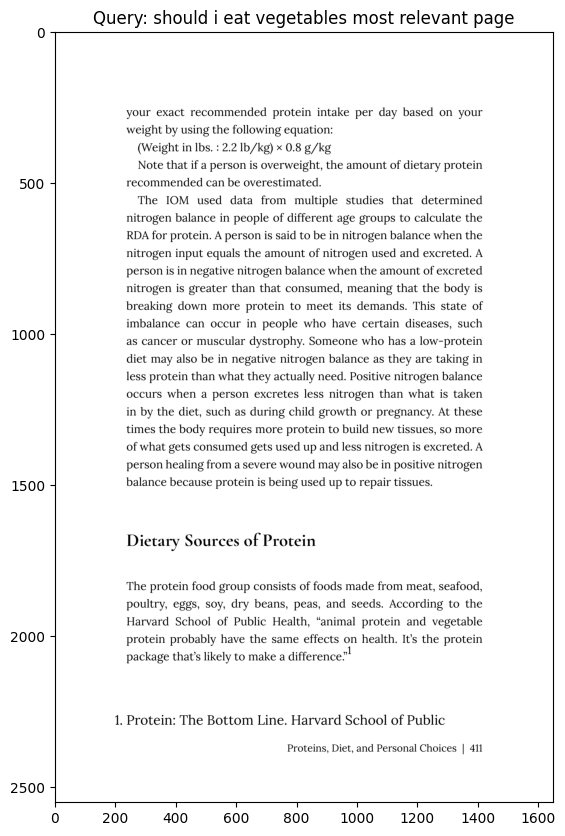

In [215]:
import fitz

pdf_path = "human-nutrition-text.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(411 + 41)

img = page.get_pixmap(dpi=300)
#img.save("pdfPage.png")

img_array = np.frombuffer(img.samples_mv, dtype=np.uint8).reshape(img.h, img.w, img.n)

import matplotlib.pyplot as plt

plt.figure(figsize=(13,10))
plt.imshow(img_array)
plt.title(f"Query: {query} most relevant page")

<h1> Similariy: dot product and cosine sim </h1>

two of the most common are dot product and cosine similarity

close vectors has higher scores, further vectors lower scores.

vector has magnitude (length / how long is it) and direction (which way is it going).
- we dont decide these values, they are learned

vectors that are aligned in direction and magnitude have a higher positive value. 
For text similarity, we want to use cosine similarity. 

In [217]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dotP = dot_product(vector1, vector2)
    #get the euclidian/l2 norm
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))
    return dotP / (norm_vector1 * norm_vector2)

#vectors eg
vector1 = torch.tensor([1,2,3], dtype=torch.float32)
vector2 = torch.tensor([1,2,3], dtype=torch.float32)
vector3 = torch.tensor([4,5,6], dtype=torch.float32)
vector4 = torch.tensor([-1,-2,-3], dtype=torch.float32)

#dot product
print("DP vector1 -> vector2", dot_product(vector1, vector2))
print("DP vector1 -> vector3", dot_product(vector1, vector3))
print("DP vector1 -> vector4", dot_product(vector1, vector4))

print("CS vector1 -> vector2", cosine_similarity(vector1, vector2))
print("CS vector1 -> vector3", cosine_similarity(vector1, vector3))
print("CS vector1 -> vector4", cosine_similarity(vector1, vector4))


DP vector1 -> vector2 tensor(14.)
DP vector1 -> vector3 tensor(32.)
DP vector1 -> vector4 tensor(-14.)
CS vector1 -> vector2 tensor(1.0000)
CS vector1 -> vector3 tensor(0.9746)
CS vector1 -> vector4 tensor(-1.0000)


Functionizing our semantic search pipeline

In [225]:
def retrieve_relevant_resources(query: str, embeddings: torch.tensor, model: SentenceTransformer=embedding_model, n_resources_to_return: int=5, print_time: bool=True):

    query_embedding = model.encode(query, convert_to_tensor=True)

    #get scores
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()
    if print_time:
        print(f"[INFO] Time taken to get scores on ({len(embeddings)}) embeddings: {end_time - start_time}s")
    
    scores, indices = torch.topk(input=dot_scores, k=n_resources_to_return)
    return scores, indices

def print_top_results_and_scores(query:str, embeddings: torch.tensor, pages_and_chunks: list[dict]=pages_and_chunks, n_resources_to_return: int=5):
    #print out the matching chunks with the embedded queries
    scores, indices = retrieve_relevant_resources("foods high in fibre", embeddings=embeddings, n_resources_to_return=n_resources_to_return)
    
    for score, idx in zip(scores, indices):
        print(f"Score: {score}")
        print("Text: ")
        print(pages_and_chunks[idx]["sentence_chunk"])
        print(f"Page Number: {pages_and_chunks[idx]['page_number']}")
        print("\n")


In [224]:
retrieve_relevant_resources("foods high in fibre", embeddings=embeddings)

[INFO] Time taken to get scores on (1680) embeddings: 5.9399986639618874e-05s


(tensor([0.6866, 0.6661, 0.5586, 0.5434, 0.5024], device='cuda:0'),
 tensor([ 360,  418,  358, 1047,  376], device='cuda:0'))

In [226]:
print_top_results_and_scores("foods high in fibre", embeddings=embeddings)

[INFO] Time taken to get scores on (1680) embeddings: 5.0300004659220576e-05s
Score: 0.5157707333564758
Text: 
form of cancer in their lifetime.6 Although cancer is one of the leading causes of death worldwide, ongoing research and innovations in treatment have improved the outlook for cancer patients to the point where millions now survive or live with cancer, making it a chronic disease. The American Institute for Cancer Research (AICR) has published guidelines for preventing cancer and staying healthy.They include several dietary and lifestyle choices, such as participating in physical activity for thirty minutes per day or more, and maintaining a healthy weight.In addition, AICR recommends consuming a plant- based diet.7 Several epidemiological studies have found a link between eating plenty of fruits and vegetables and a low incidence of certain cancers.Fruits and vegetables containing a wide variety of nutrients and phytochemicals may either prevent or reduce the oxidative damage

Getting LLMs for local generation

focuses on local RAG generation, however will work with an API